# Block Diagram Systems

Core idea: Functional blocks can be connected together, block-diagram style, to build systems of larger complexity. The fundamental unit -- a "System" -- has a very specific contract that supports both modularity and ease of analysis.

High-level docs and solid examples:
http://underactuated.csail.mit.edu/underactuated.html?chapter=systems

Details docs:
http://drake.mit.edu/doxygen_cxx/group__systems.html

In short, systems can:
- Have any number of vector-valued (or abstract-valued) inputs
- Have any number of vector-valued (or abstract-valued) outputs
- Have vector-valued continuous state, for which it supplies time derivatives
- Have vector-valued or abstract-valued discrete state, for which it supplies update rules
- Operate on float/double, but also autodiff and symbolic types.
- Be assembled by connecting smaller systems.

And systems must:
- Be deterministic given their inputs. (Randomness must only come a special kind of input port.)
- Declare certain flags (e.g. direct feedthrough).

In [1]:
from pydrake.all import (VectorSystem)
# Subclasses VectorSystem, which provides
# a convenient constructor for a System
# with 1 vector-valued input and 1 vector-valued output.
class SimpleContinuousTimeSystem(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self,
            0,                           # Zero inputs.
            1)                           # One output.
        self.set_name("Simple Continuous Time System")
        self._DeclareContinuousState(1)  # One state variable.

    # xdot(t) = -x(t) + x^3(t)
    def _DoCalcVectorTimeDerivatives(self, context, u, x, xdot):
        xdot[:] = -x + x**3

    # y(t) = x(t)
    def _DoCalcVectorOutput(self, context, u, x, y):
        y[:] = x
        
# Same idea as above, but instead we create the system with
# discrete state.
class SimpleDiscreteTimeSystem(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self,
            0,                                    # Zero inputs.
            1)                                    # One output.
        self._DeclareDiscreteState(1)             # One state variable.
        self._DeclarePeriodicDiscreteUpdate(1.0)  # One second timestep.

    # x[n+1] = x[n]^3
    def _DoCalcVectorDiscreteVariableUpdates(self, context, u, x, xnext):
        xnext[:] = x**3

    # y[n] = x[n]
    def _DoCalcVectorOutput(self, context, u, x, y):
        y[:] = x

## Diagrams

Systems on their own wouldn't be very interesting, so here's how to plug them together. In this case, we're appending a ["SignalLogger"](http://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_signal_logger.html#details) system to record the output of the system we wrote.

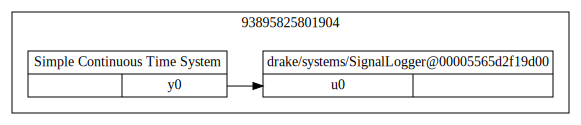

In [2]:
from pydrake.all import (DiagramBuilder, SignalLogger)
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(SimpleContinuousTimeSystem())
logger = builder.AddSystem(SignalLogger(1))
builder.Connect(system.get_output_port(0), logger.get_input_port(0))
diagram = builder.Build()

# Visualize
from graphviz import Source
string = diagram.GetGraphvizString()
Source(string)

## Diagrams and Simulation

To make these systems do something interesting, we need to simulate them -- a combination of integrating the continuous state forward in time and keeping track of discrete state updates, while keeping inputs and outputs between systems synchonized. Drake's [Simulator](http://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_simulator.html#details) handles this.

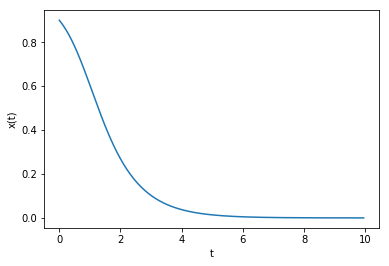

In [3]:
import matplotlib.pyplot as plt
from pydrake.all import (Simulator)

# Create the simulator.
simulator = Simulator(diagram)

# Set the initial conditions, x(0).
state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
state.SetFromVector([0.9])

# Simulate for 10 seconds.
simulator.StepTo(10)

# Plot the results.
plt.plot(logger.sample_times(), logger.data().transpose())
plt.xlabel('t')
plt.ylabel('x(t)');